# Final Project DL model Notebook - Retrain Model From User Data

improve and adapt model using data collected in the real world

In [1]:
import sys

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

# Model and data dirs
current_dir = Path.cwd()
MODEL_NAME = 'CNN_two_convs_30122017_1700.h5'
HOME_DIR = current_dir.parent
MODEL_DIR = HOME_DIR.joinpath('savedModels/30122017/')
MODEL = MODEL_DIR.joinpath(MODEL_NAME)

DATA_DIR = HOME_DIR.joinpath('data/')
VAL_DATA_DIR = DATA_DIR.joinpath('valid')
RETRAIN_DATA_DIR = DATA_DIR.joinpath('retrainBatch01-28-02-2018/labelled/')


# training variables
batch_size = 64
epochs = 5
learning_rate = 1e-5

/Users/pgieschen/anaconda/envs/finalProject/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
model = load_model(MODEL)
model.summary()

/Users/pgieschen/anaconda/envs/finalProject/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 72, 72)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 72, 72)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 24, 24)        0         
__________

## Validate current performance of the loaded model

we loaded the existing model, and now run a quick test to see how the model is currently performing on the validation data set as a benchmark

In [3]:
validation_generator_2 = get_val_data_in_batches(VAL_DATA_DIR,batch_size=batch_size, target_size=(224, 224))
perf = [model.evaluate_generator(validation_generator_2, validation_generator_2.n // batch_size) for i in range(10)]

Found 5000 images belonging to 10 classes.


In [4]:
print(model.metrics_names)
np.round(perf, 6)

['loss', 'acc']


array([[0.014464, 0.996795]])

## Now we are going to retrain the classifier on the new data that we collected from the users

In [5]:
# setting a low learning rate, as the model is already quite good, and we merely want it to adapy better to the 
# generated data
model.optimizer.lr.set_value(learning_rate)
retrain_batches = get_in_batches(RETRAIN_DATA_DIR, batch_size=batch_size, augment=True)
val_batches = get_in_batches(VAL_DATA_DIR, batch_size=batch_size, augment=True)

Found 181 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [6]:
history = model.fit_generator(retrain_batches,
                    steps_per_epoch=retrain_batches.n//retrain_batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=1,
                    epochs=epochs,
                    callbacks=[reduce_lr, stop_early])

Epoch 1/5
2/2 [==============================] - 49s 24s/step - loss: 7.8088 - acc: 0.1328 - val_loss: 3.0172 - val_acc: 0.6094
Epoch 2/5
2/2 [==============================] - 39s 20s/step - loss: 8.9031 - acc: 0.0951 - val_loss: 3.6464 - val_acc: 0.5469
Epoch 3/5
2/2 [==============================] - 42s 21s/step - loss: 8.5892 - acc: 0.0699 - val_loss: 2.6306 - val_acc: 0.6094
Epoch 4/5
2/2 [==============================] - 43s 21s/step - loss: 8.1840 - acc: 0.1376 - val_loss: 3.2576 - val_acc: 0.5781
Epoch 5/5
2/2 [==============================] - 41s 21s/step - loss: 9.2366 - acc: 0.0779 - val_loss: 3.1850 - val_acc: 0.5625


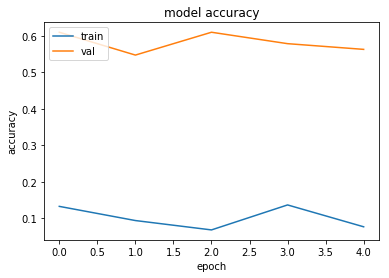

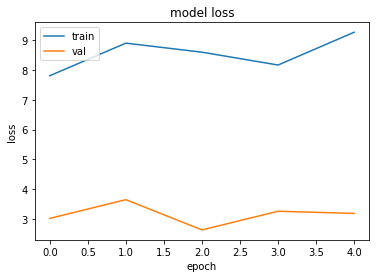

In [7]:
plot_acc_and_loss(history)